In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import io
import cv2 

from google.cloud import vision
from pytesseract import Output
from pytesseract import pytesseract as pt
from PIL import Image, ImageDraw
from glob import glob

## 검증용 데이터셋 준비

In [2]:
fold_path = os.getenv('HOME')+'/repo/LibRobo/data/img/'
os.listdir(fold_path)

['lib_16.jpg',
 'lib_15.jpg',
 'lib_10.jpg',
 'lib_4.jpg',
 'lib_18.jpg',
 'lib_22.jpg',
 'lib_3.jpg',
 'lib_9.jpg',
 'lib_2.jpg',
 'lib_6.jpg',
 'lib_8.jpg',
 'lib_19.jpg',
 'lib_12.jpg',
 'lib_13.jpg',
 'lib_11.jpg',
 'lib_5.jpg',
 'lib_21.jpg',
 'lib_1.jpg',
 'lib_20.jpg',
 'lib_17.jpg',
 'lib_7.jpg',
 'lib_14.jpg']

In [3]:
def changeName(path, cName):
    for i, filename in enumerate(os.listdir(path)):
        if cName in filename:
            continue
        os.rename(path+filename, path+str(cName)+'_'+str(i+1)+'.jpg')

In [4]:
changeName(fold_path, 'lib')

images_path = glob(fold_path+'*.jpg')
images_path

['/home/when/repo/LibRobo/data/img/lib_16.jpg',
 '/home/when/repo/LibRobo/data/img/lib_15.jpg',
 '/home/when/repo/LibRobo/data/img/lib_10.jpg',
 '/home/when/repo/LibRobo/data/img/lib_4.jpg',
 '/home/when/repo/LibRobo/data/img/lib_18.jpg',
 '/home/when/repo/LibRobo/data/img/lib_22.jpg',
 '/home/when/repo/LibRobo/data/img/lib_3.jpg',
 '/home/when/repo/LibRobo/data/img/lib_9.jpg',
 '/home/when/repo/LibRobo/data/img/lib_2.jpg',
 '/home/when/repo/LibRobo/data/img/lib_6.jpg',
 '/home/when/repo/LibRobo/data/img/lib_8.jpg',
 '/home/when/repo/LibRobo/data/img/lib_19.jpg',
 '/home/when/repo/LibRobo/data/img/lib_12.jpg',
 '/home/when/repo/LibRobo/data/img/lib_13.jpg',
 '/home/when/repo/LibRobo/data/img/lib_11.jpg',
 '/home/when/repo/LibRobo/data/img/lib_5.jpg',
 '/home/when/repo/LibRobo/data/img/lib_21.jpg',
 '/home/when/repo/LibRobo/data/img/lib_1.jpg',
 '/home/when/repo/LibRobo/data/img/lib_20.jpg',
 '/home/when/repo/LibRobo/data/img/lib_17.jpg',
 '/home/when/repo/LibRobo/data/img/lib_7.jpg',
 

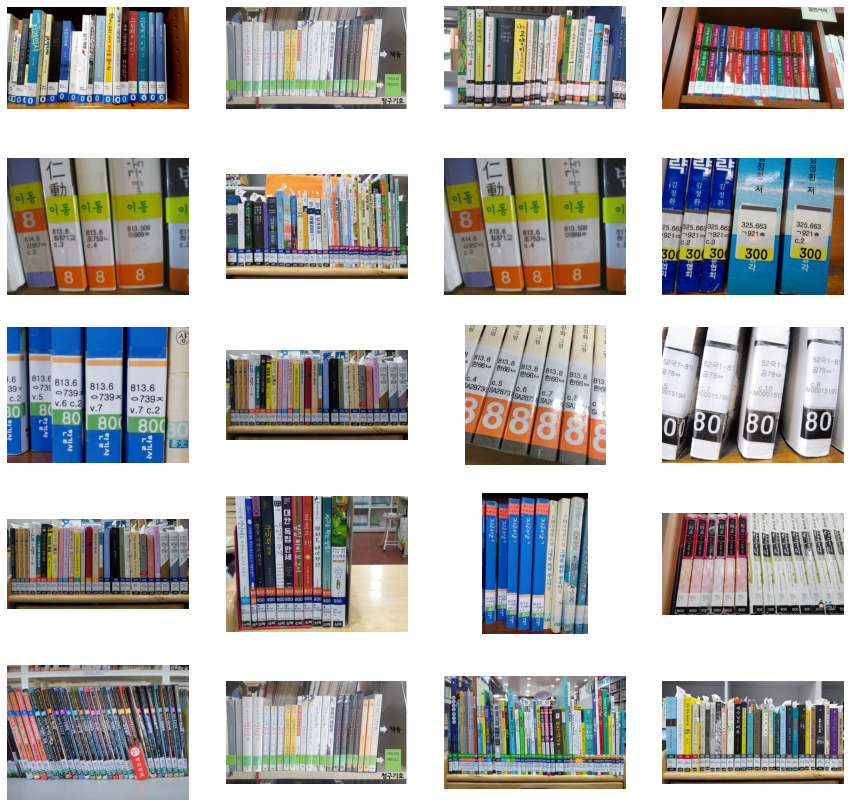

In [5]:
plt.figure(figsize=(15, 15))

for idx, image in enumerate(images_path[:20]):
    plt.subplot(5, 4, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

위의 이미지들은 학생증 자동인식 기능이라는 서비스를 만들기 위한 데이터셋이다. 학생증을 식별하기 위해 중요한 데이터가 여러가지이지만, 대표적으로 뽑아보자면.
1. 학생증 번호 (학번)
2. 학생 이름
3. 학교, 전공 이름
4. 기타
가 있을 것이다.  

위의 데이터를 검출하기 위해서는 OCR기능이 필요하다. 그 중 세 가지 OCR (Google OCR API, keras-ocr, Tesseract)을 활용해보고 데이터가 잘 검출되는지 테스트 해볼 것이다.

## OCR API

In [6]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [7]:
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    s = os.path.splitext(path)
    s = os.path.split(s[0])
    name = s[1]
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [8]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

ocr_img = []
ocr_dict = {}
# # 입력 이미지 경로를 지정해 주세요.
# path = '/home/when/repo/LibRobo/data/img/Lib_3.jpg'

# # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in images_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

-rw-rw-r-- 1 when when 2342  1월  9 16:23 /home/when/repo/LibRobo/data/my_google_api_key.json


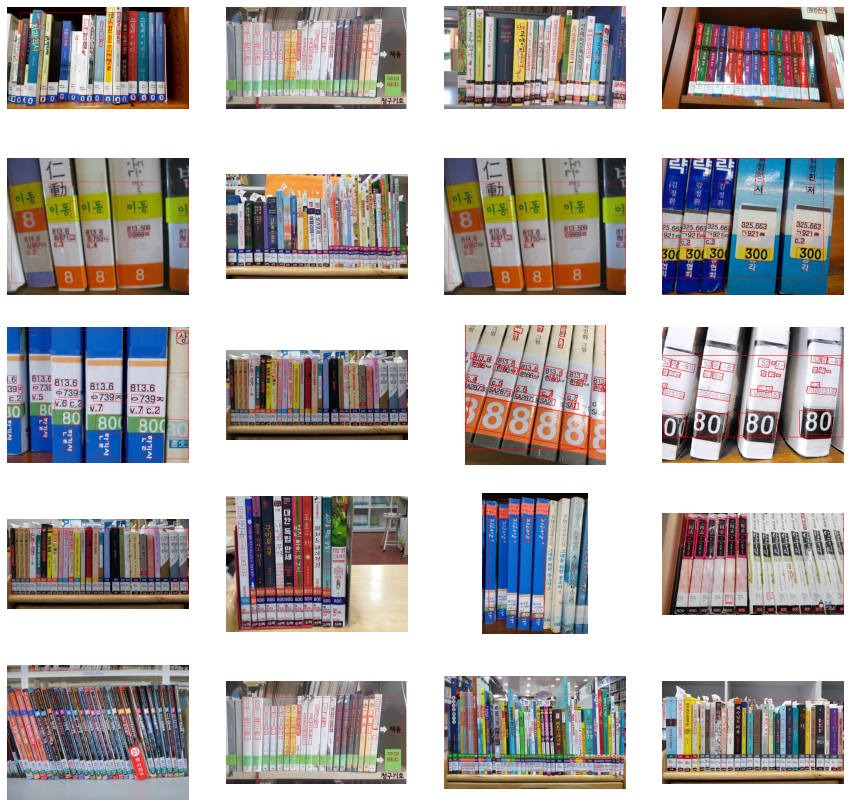

In [10]:
plt.figure(figsize=(15, 15))

for idx, img in enumerate(ocr_img[:20]):
    plt.subplot(5, 4, idx+1)
    plt.imshow(img)
    plt.axis('off')

### 검출 결과

첫 번째 사용한 기술은 Google의 OCR API 기술이다. 구글은 여러가지 이미지 관련 클라우드 서비스를 제공하고 있다. https://console.cloud.google.com/ 에 접속해서 사용 권한을 얻고 JSON파일을 가져오면 쉽게 사용이 가능하다.   

사용 결과, 준수한 성능을 보이고 있다. 빨간색 박스가 글씨를 제대로 검출했다는 지표인데 대부분 올바르게 검출이 잘되었다. 하지만 15번째 사진은 어째서인지 검출이 잘 되지 않았다. 그래도 이정도면 괜찮은 성적이다. 

In [39]:
def visual():
    print('원하는 이미지 번호를 입력하세요: ')
    num = str(input())
    name = 'lib_'+num
    idx = list(ocr_dict.keys()).index(name)
    print(ocr_dict[name])
    plt.figure(figsize=(15, 15))
    plt.imshow(ocr_img[idx])

원하는 이미지 번호를 입력하세요: 


 20


["ALS아동가통아g아아동아 아동 아동 마루아아아동아문 아동 아통 아동 아동아동이 유이유아 유아 유아200 200 20030303030 30800 30 3080(500 40 400 50050607(70C8(800 800 BOBC8080(80 800800 800 800 800 80(8030 906060(200 200 B0(80800 80080 80 800 80os D s alos 8 os os lo s5 a5ars as ars 0a 380. R SR813.J813903n A 813.g3A294 a2sJ765S2olion2110dukuzda21124 2s21111113 21 2114 21142eP142112/1211321132113 134 21135 36신착신착신착FAR도망1, 누대대!한 입만9 동 판다 D안녕, 나의 문동화e un a파티에 간 사자미용실에 간 사자27 IE BI A A내 기가 더 커!고구마구마 wa|品동성하나님이 나를만드셨어요 ode 류Mix iT UP!Hense'TuletHeave Tullat신트바트와 티나는 위태한 모형LET'S PLAY!모두의 태극기** 브린들 주세요쁘104층 나무 집 &티크IRIERala수명 숙제엄마는 마녀 아 쁘담을 널은 아이DaD E MA서NAALLLTOY왜 맞춤법에 맞게 써야 돼 ?보이 리 인 로이네 집PR 소 에너지 연구소부루에게 수영을 가르질 걸 그랬어!공룡의 생태만화로경 말型e 5 성제승이 인간탐구보고개州세계 시민 4업세계 시민 4업 9)환경정의빼앗긴 사람들F즉에는 규칙이 있어요!학교에는 규칙이 있어요!.DT:TOBLR김여는 규회에 있어요!HIOOLJ 학생이란?종은 어른이란?AUN EO MOY4", 'ALS', '아동가', '통아', 'g', '아아', '동아', '아동', '아동', '마루', '아아아', '동아', '문', '아동', '아통', '아동', '아동', '아동', '이', '유이', '유아', '유아', '유아', '200', '200', '20030303030', '30800', '30', '3

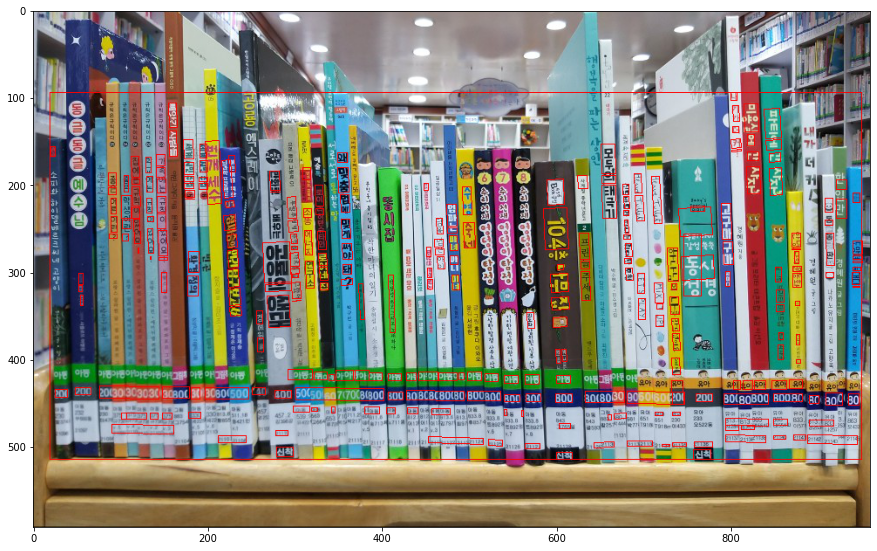

In [40]:
visual()

### 텍스트 검출 결과

여러가지 이미지 중 임의로 한개의 이미지를 골라서 비교해보았다. 위의 이미지가 윈본이라고 할 때 텍스트를 비교해보자. 
- 원본 이미지: ['Curtin', 'STUDENT', 'CITIZEN', 'University', 'John', '12345678' ]
- OCR API: ['Curtin','STUDENT','CITIZEN', 'University', 'John', '12345678']
- keras-ocr: [curtin, student, citizen,  university,  jonn,  1224s676 ]
- Tesseract:['StUDENT', 'CITLZEN', '12345678', 'a', 'PI']

원본 이미지에 비해 OCR API는 대략 100%, keras-ocr은 70%, Tesseract는 50% 정도의 성능을 보여준다. 
만약 위의 세가지 모델 중에서 OCR 서비스에 적용해야 된다고 한다면 구글의 OCR API를 도입할 것이다. 정확도 뿐만 아니라 대소문자 구분까지 완벽하기 때문이다.  